In [1]:
import os
import sys
from itertools import chain, product
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Patch
from scipy.stats import spearmanr
from tqdm import tqdm, tqdm_notebook
import statsmodels.formula.api as smf

from joblib import load
from pathos.multiprocessing import ProcessingPool as Pool

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
import CPC_package as CPC
import random

%matplotlib inline

# Heatmap

In [2]:
df_AddHealth = load('df_AddHealth.joblib')
df_Banerjee = load('df_Banerjee.joblib')
df_WS = load('df_WS.joblib')

In [3]:
#calculate the portion of entries in the dataframes with per tie range
total_entries_AddHealth = len(df_AddHealth)
total_entries_Banerjee = len(df_Banerjee)
total_entries_WS = len(df_WS)
tie_range_counts_AddHealth = df_AddHealth['Tie_range'].value_counts().sort_index()
tie_range_counts_Banerjee = df_Banerjee['Tie_range'].value_counts().sort_index()
tie_range_counts_WS = df_WS['Tie_range'].value_counts().sort_index()
tie_range_portion_AddHealth = tie_range_counts_AddHealth / total_entries_AddHealth
tie_range_portion_Banerjee = tie_range_counts_Banerjee / total_entries_Banerjee
tie_range_portion_WS = tie_range_counts_WS / total_entries_WS
print("Portion of entries in df_AddHealth by Tie_range:")
print(tie_range_portion_AddHealth)
print("\nPortion of entries in df_Banerjee by Tie_range:")
print(tie_range_portion_Banerjee)
print("\nPortion of entries in df_WS by Tie_range:")
print(tie_range_portion_WS)

Portion of entries in df_AddHealth by Tie_range:
Tie_range
2     0.667289
3     0.176704
4     0.095796
5     0.040792
6     0.012888
7     0.004480
8     0.001489
9     0.000413
10    0.000107
11    0.000004
12    0.000040
Name: count, dtype: float64

Portion of entries in df_Banerjee by Tie_range:
Tie_range
0    0.000459
2    0.917352
3    0.066881
4    0.012551
5    0.002514
6    0.000213
7    0.000029
Name: count, dtype: float64

Portion of entries in df_WS by Tie_range:
Tie_range
2     4.692794e-01
3     3.032944e-01
4     2.127006e-01
5     1.256437e-02
6     1.496250e-03
7     3.818750e-04
8     1.487500e-04
9     5.312500e-05
10    3.125000e-05
11    2.375000e-05
12    9.375000e-06
13    5.000000e-06
14    5.625000e-06
15    6.250000e-07
16    6.250000e-07
17    2.500000e-06
18    1.875000e-06
19    6.250000e-07
Name: count, dtype: float64


In [4]:
def process_dataframe(df, dataset_name):
    # Filter relevant columns and drop rows with missing values
    df_filtered = df[['Tie_range', 'CPC_max', 'CPC_difference']].dropna()

    # Rename columns for readability in regression formula
    df_filtered = df_filtered.rename(columns={
        'Tie_range': 'Tie_Range',
        'CPC_max': 'Max_of_the_Tie_Importances_for_each_Tie',
        'CPC_difference': 'Tie_Importance_Delta'
    })

    # Fit OLS regression model with interaction term
    model = smf.ols('Tie_Importance_Delta ~ Tie_Range * Max_of_the_Tie_Importances_for_each_Tie', data=df_filtered).fit()

    # Print model results
    print(f"\n=== Results for {dataset_name} ===")
    print(f"R-squared: {model.rsquared:.3f}")
    print(f"Adj. R-squared: {model.rsquared_adj:.3f}")
    print("\nCoefficients:")
    summary_df = pd.DataFrame({
        "Coefficient": model.params.round(8),
        "Std_Err": model.bse.round(8),
        "p_value": model.pvalues.round(8),
        "N": model.nobs
    })
    print(summary_df)

    return model

model_AddHealth = process_dataframe(df_AddHealth, "AddHealth")
model_Banerjee  = process_dataframe(df_Banerjee, "Banerjee")
model_WS        = process_dataframe(df_WS, "Watts-Strogatz")


=== Results for AddHealth ===
R-squared: 0.605
Adj. R-squared: 0.605

Coefficients:
                                                   Coefficient   Std_Err  \
Intercept                                            -0.002523  0.000082   
Tie_Range                                             0.000275  0.000028   
Max_of_the_Tie_Importances_for_each_Tie               0.324362  0.000525   
Tie_Range:Max_of_the_Tie_Importances_for_each_Tie     0.044745  0.000207   

                                                   p_value          N  
Intercept                                              0.0  4500420.0  
Tie_Range                                              0.0  4500420.0  
Max_of_the_Tie_Importances_for_each_Tie                0.0  4500420.0  
Tie_Range:Max_of_the_Tie_Importances_for_each_Tie      0.0  4500420.0  

=== Results for Banerjee ===
R-squared: 0.692
Adj. R-squared: 0.692

Coefficients:
                                                   Coefficient   Std_Err  \
Intercept     

In [5]:
def process_dataframe(df, dataset_name):
    # Filter relevant columns and drop rows with missing values
    df_filtered = df[['Tie_range', 'CPC_max', 'CPC_difference']].dropna()

    # Rename columns for readability in regression formula
    df_filtered = df_filtered.rename(columns={
        'Tie_range': 'Tie_Range',
        'CPC_max': 'Max_of_the_Tie_Importances_for_each_Tie',
        'CPC_difference': 'Tie_Importance_Delta'
    })

    # Fit OLS regression model without interaction term
    model = smf.ols('Tie_Importance_Delta ~ Tie_Range + Max_of_the_Tie_Importances_for_each_Tie', data=df_filtered).fit()

    # Print model results
    print(f"\n=== Results for {dataset_name} ===")
    print(f"R-squared: {model.rsquared:.3f}")
    print(f"Adj. R-squared: {model.rsquared_adj:.3f}")
    print("\nCoefficients:")
    summary_df = pd.DataFrame({
        "Coefficient": model.params.round(8),
        "Std_Err": model.bse.round(8),
        "p_value": model.pvalues.round(8),
        "N": model.nobs
    })
    print(summary_df)

    return model

model_AddHealth = process_dataframe(df_AddHealth, "AddHealth")
model_Banerjee  = process_dataframe(df_Banerjee, "Banerjee")
model_WS        = process_dataframe(df_WS, "Watts-Strogatz")


=== Results for AddHealth ===
R-squared: 0.600
Adj. R-squared: 0.600

Coefficients:
                                         Coefficient   Std_Err  p_value  \
Intercept                                  -0.011793  0.000070      0.0   
Tie_Range                                   0.003873  0.000023      0.0   
Max_of_the_Tie_Importances_for_each_Tie     0.432046  0.000167      0.0   

                                                 N  
Intercept                                4500420.0  
Tie_Range                                4500420.0  
Max_of_the_Tie_Importances_for_each_Tie  4500420.0  

=== Results for Banerjee ===
R-squared: 0.688
Adj. R-squared: 0.688

Coefficients:
                                         Coefficient   Std_Err  p_value  \
Intercept                                  -0.012485  0.000077      0.0   
Tie_Range                                   0.006266  0.000036      0.0   
Max_of_the_Tie_Importances_for_each_Tie     0.462194  0.000119      0.0   

                 

In [6]:
#filter the dataframes to only include tie ranges between 2 and 6 as everything else almost never occurs
df_AddHealth = df_AddHealth[(df_AddHealth['Tie_range'] >= 2) & (df_AddHealth['Tie_range'] <= 6)]
df_Banerjee = df_Banerjee[(df_Banerjee['Tie_range'] >= 2) & (df_Banerjee['Tie_range'] <= 6)]
df_WS = df_WS[(df_WS['Tie_range'] >= 2) & (df_WS['Tie_range'] <= 6)]

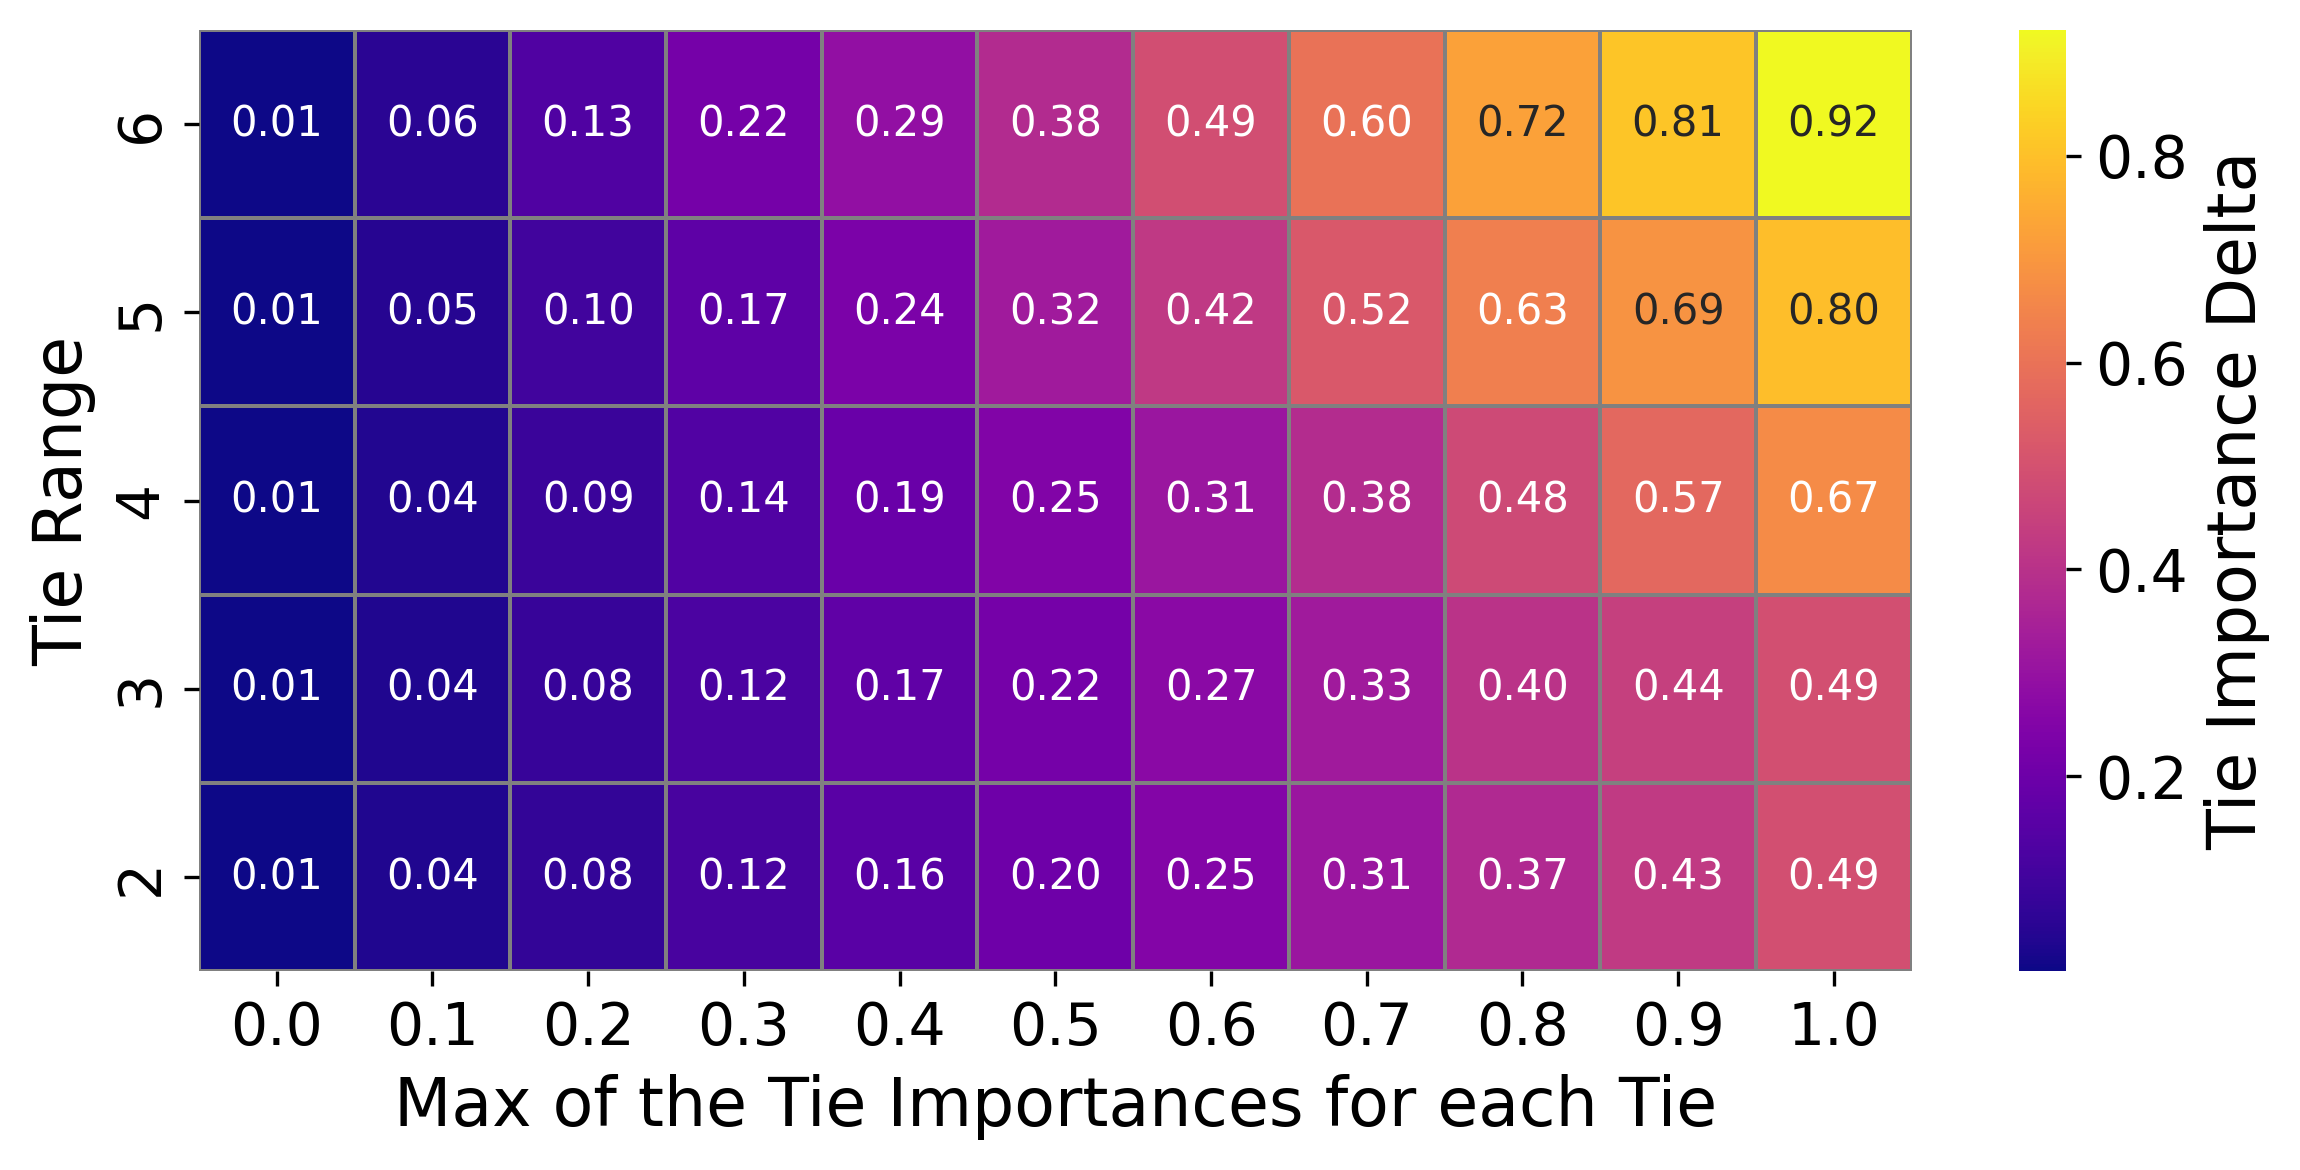

In [7]:
df_AddHealth['CPC_max'] = df_AddHealth['CPC_max'].round(1)

# Create pivot table
heatmap_data_Addhealth = df_AddHealth.pivot_table(index='Tie_range', columns='CPC_max', values='CPC_difference', aggfunc='mean')
all_ranges = list(range(2, 7))  # 9 is exclusive, so it gives 2 to 8
heatmap_data_Addhealth = heatmap_data_Addhealth.reindex(index=all_ranges)

# Plot heatmap
plt.figure(figsize=(8, 4), dpi=300)
ax = sns.heatmap(heatmap_data_Addhealth, cmap='plasma', annot=True, fmt=".2f", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Tie Importance Delta'})

ax.invert_yaxis()

# Get the colorbar from the heatmap
cbar = ax.collections[0].colorbar
# Increase the tick label size of the colorbar
cbar.ax.tick_params(labelsize=14)
# Also, set the colorbar label's font size
cbar.set_label('Tie Importance Delta', fontsize=16)

# Labels and formatting
plt.xlabel('Max of the Tie Importances for each Tie', fontsize=16)
plt.ylabel('Tie Range', fontsize=16)
#plt.ylim(0, 7)

# Increase label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Save figure
plt.tight_layout()
plt.savefig('heatmap_mean_cpc_tie_range_max_CPC.png', dpi=300)
plt.show()


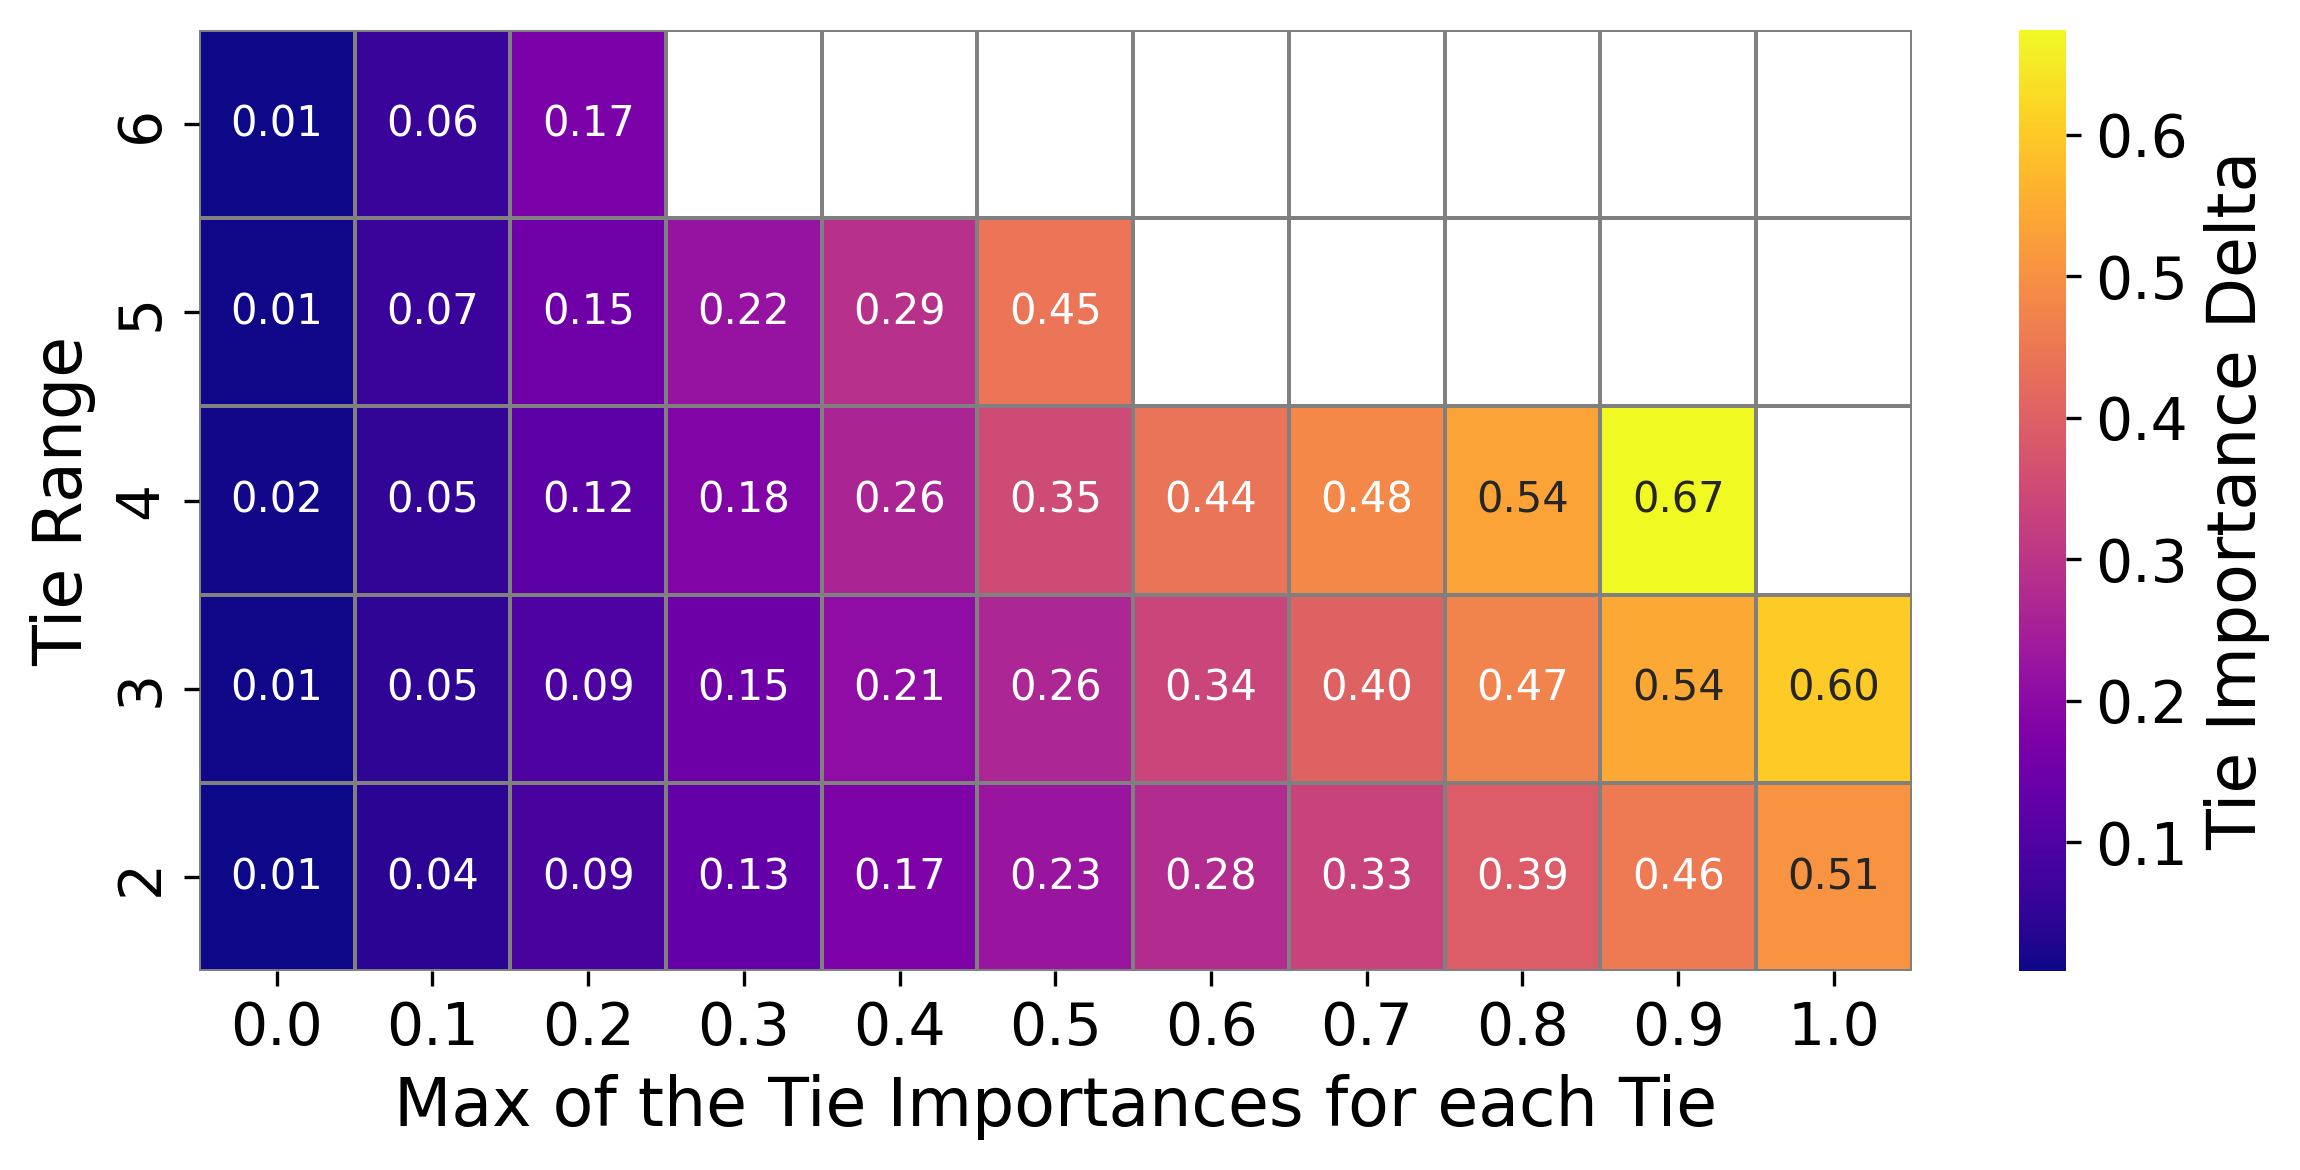

In [8]:
df_Banerjee['CPC_max'] = df_Banerjee['CPC_max'].round(1)

# Create pivot table
heatmap_data_Banerjee = df_Banerjee.pivot_table(index='Tie_range', columns='CPC_max', values='CPC_difference', aggfunc='mean')
all_ranges = list(range(2, 7))  # 9 is exclusive, so it gives 2 to 8
heatmap_data_Banerjee = heatmap_data_Banerjee.reindex(index=all_ranges)

# Plot heatmap 
plt.figure(figsize=(8, 4), dpi=300)
ax = sns.heatmap(heatmap_data_Banerjee, cmap='plasma', annot=True, fmt=".2f", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Tie Importance Delta', 'shrink': 1.0})

ax.invert_yaxis()

# Get the colorbar from the heatmap
cbar = ax.collections[0].colorbar
# Increase the tick label size of the colorbar
cbar.ax.tick_params(labelsize=14)
# Also, set the colorbar label's font size
cbar.set_label('Tie Importance Delta', fontsize=16)

# Labels and formatting
plt.xlabel('Max of the Tie Importances for each Tie', fontsize=16)
plt.ylabel('Tie Range', fontsize=16)

#plt.ylim(0, 7)

# Increase label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Save figure
plt.tight_layout()
plt.savefig('heatmap_mean_cpc_tie_range_max_CPC_Banerjee.png', dpi=300)
plt.show()


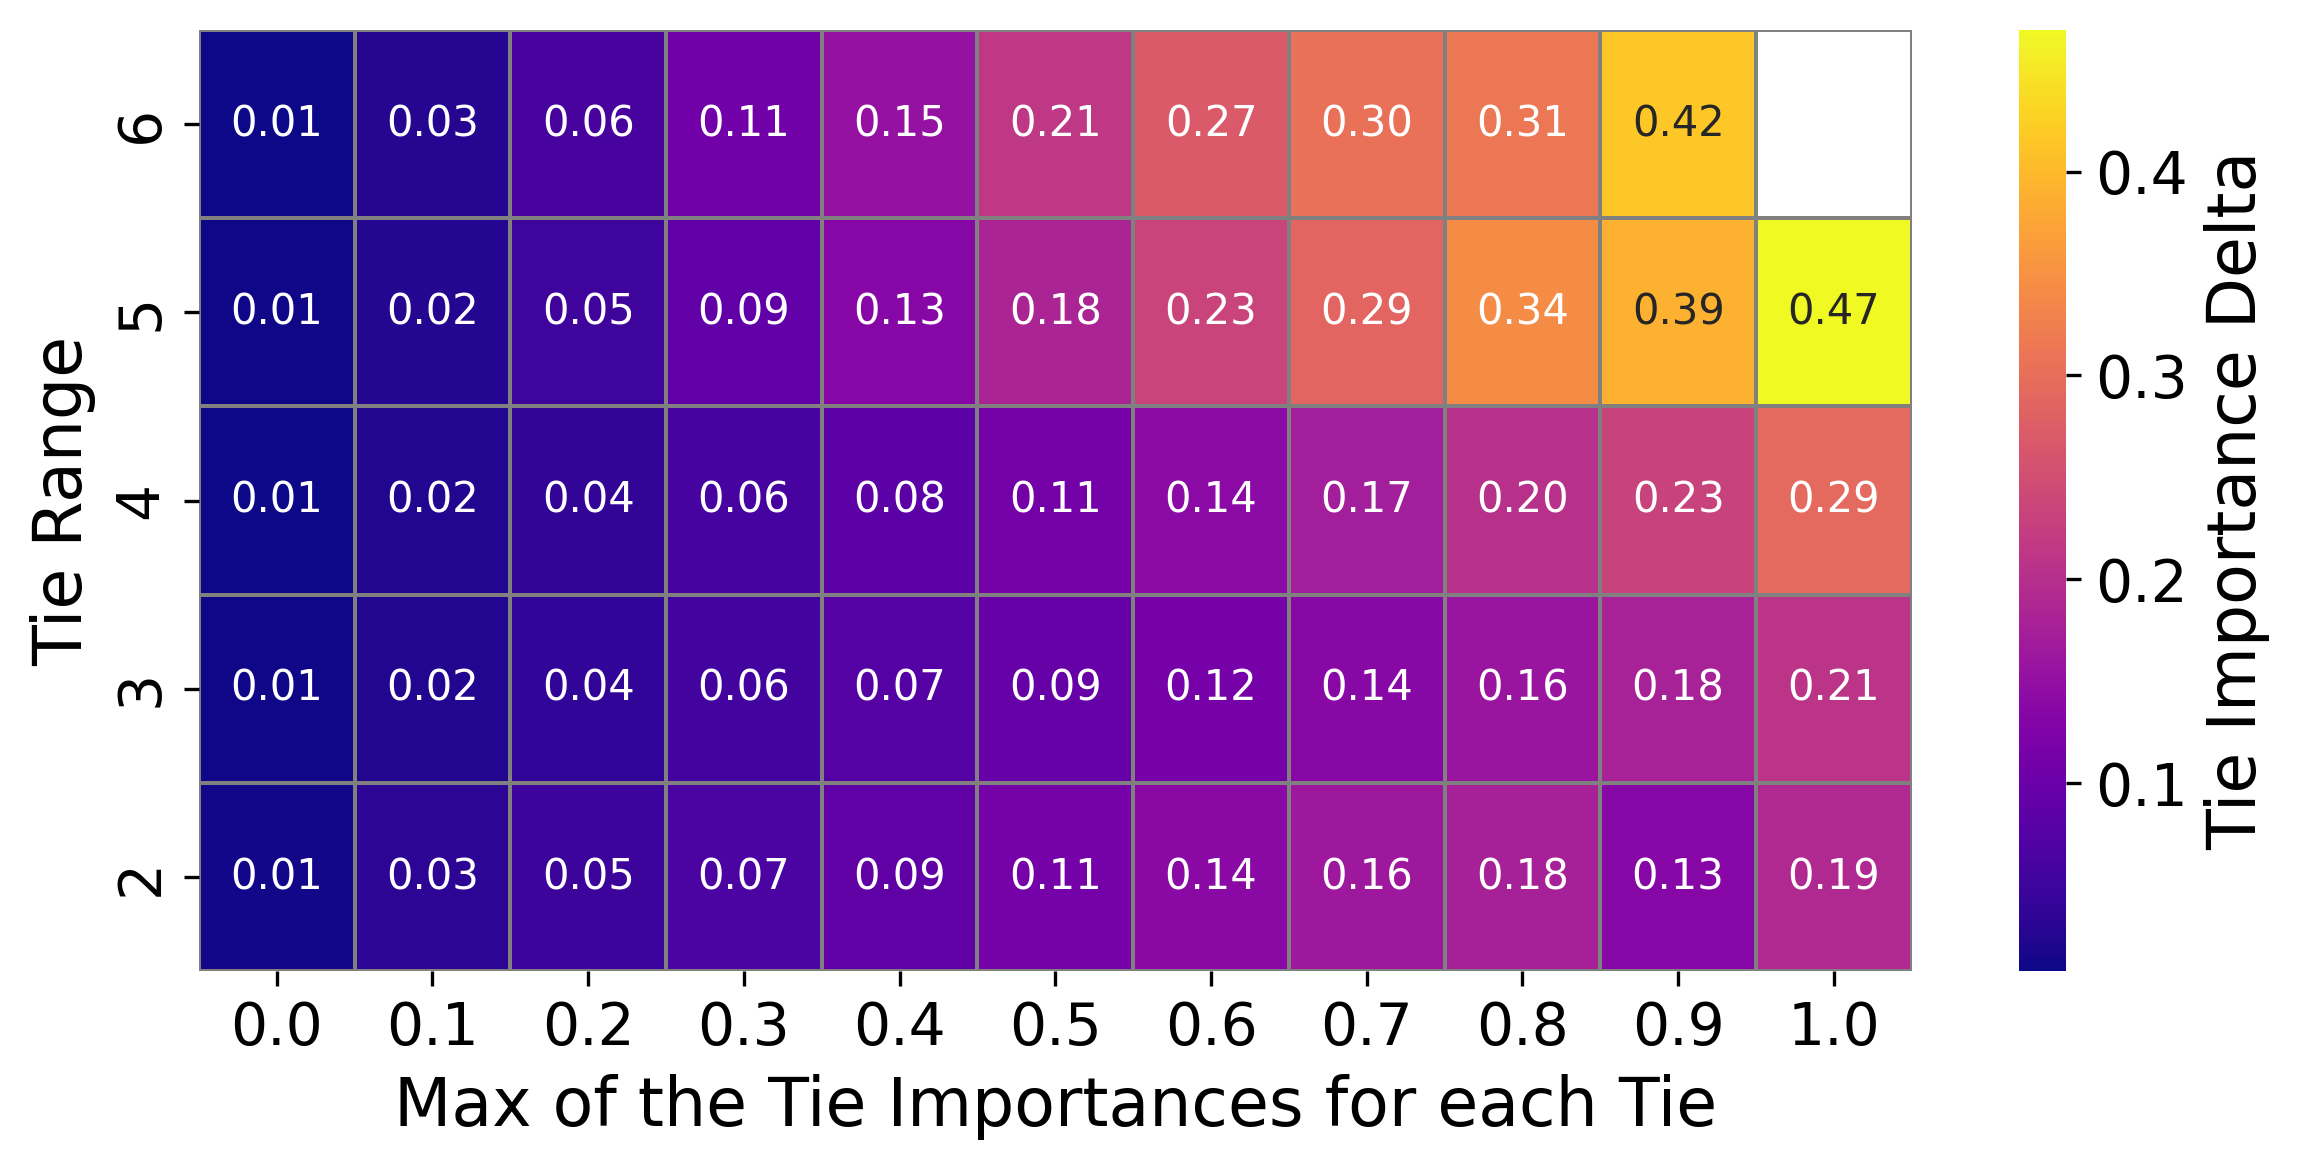

In [9]:
df_WS['CPC_max'] = df_WS['CPC_max'].round(1)

# Create pivot table
heatmap_data_WS = df_WS.pivot_table(index='Tie_range', columns='CPC_max', values='CPC_difference', aggfunc='mean')
all_ranges = list(range(2, 7))  # 9 is exclusive, so it gives 2 to 8
heatmap_data_WS = heatmap_data_WS.reindex(index=all_ranges)

# Plot heatmap 
plt.figure(figsize=(8, 4), dpi=300)
ax = sns.heatmap(heatmap_data_WS, cmap='plasma', annot=True, fmt=".2f", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Tie Importance Delta', 'shrink': 1.0})

ax.invert_yaxis()

# Get the colorbar from the heatmap
cbar = ax.collections[0].colorbar
# Increase the tick label size of the colorbar
cbar.ax.tick_params(labelsize=14)
# Also, set the colorbar label's font size
cbar.set_label('Tie Importance Delta', fontsize=16)

# Labels and formatting
plt.xlabel('Max of the Tie Importances for each Tie', fontsize=16)
plt.ylabel('Tie Range', fontsize=16)


# Increase label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Save figure
plt.tight_layout()
plt.savefig('heatmap_mean_cpc_tie_range_max_CPC_WS.png', dpi=300)
plt.show()


In [10]:
df_WS_beta_015 = df_WS[(df_WS['beta'] < 0.2) & (df_WS['beta'] > 0.1)]
df_WS = df_WS_beta_015

/var/folders/w_/tpd5jlcs0437ct5ghvt_2kqh0000gn/T/ipykernel_83058/2598888813.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_AddHealth, x='Tie_range', y='CPC_sum', palette='viridis', errorbar='sd', label='Add Health')
/var/folders/w_/tpd5jlcs0437ct5ghvt_2kqh0000gn/T/ipykernel_83058/2598888813.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_Banerjee, x='Tie_range', y='CPC_sum', palette='viridis', errorbar='sd', label='Banerjee')
/var/folders/w_/tpd5jlcs0437ct5ghvt_2kqh0000gn/T/ipykernel_83058/2598888813.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_WS, x='Tie_range', y='CPC_sum', palette='viridis', errorbar='sd', label='WS')


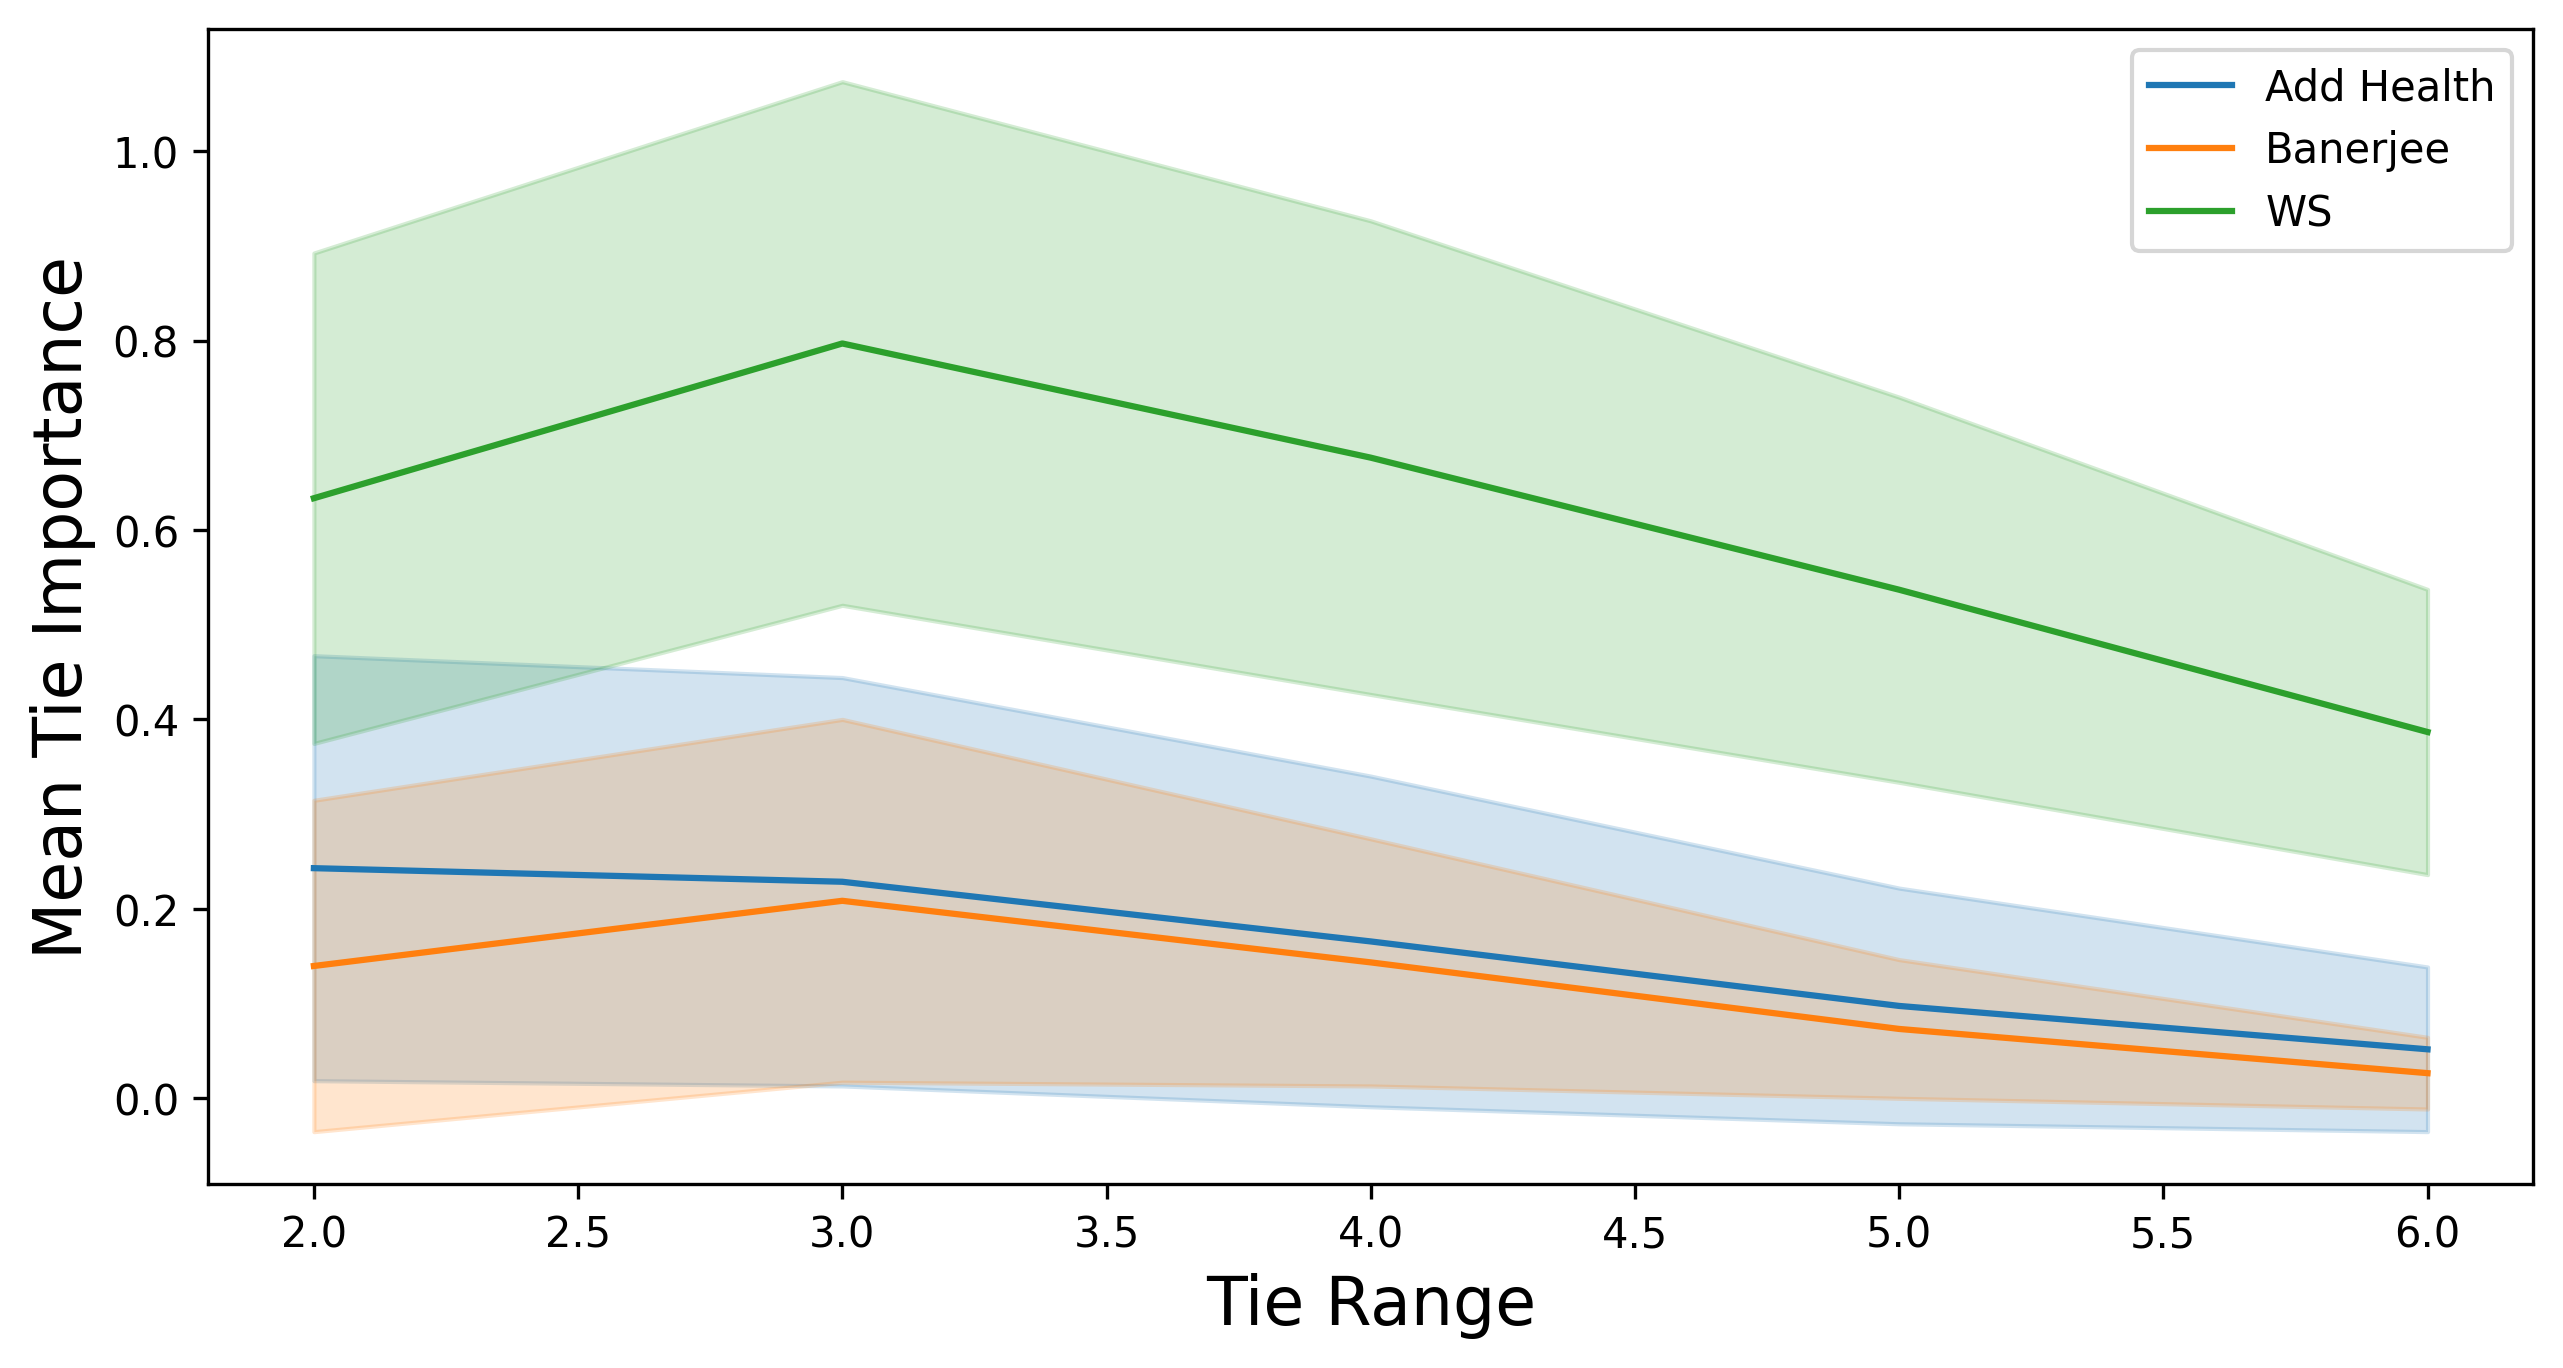

In [11]:
plt.figure(figsize=(10, 5), dpi=300)
sns.lineplot(data=df_AddHealth, x='Tie_range', y='CPC_sum', palette='viridis', errorbar='sd', label='Add Health')
sns.lineplot(data=df_Banerjee, x='Tie_range', y='CPC_sum', palette='viridis', errorbar='sd', label='Banerjee')
sns.lineplot(data=df_WS, x='Tie_range', y='CPC_sum', palette='viridis', errorbar='sd', label='WS')
plt.ylabel('Mean Tie Importance', fontsize=16)
plt.xlabel('Tie Range', fontsize=16)
plt.savefig('lineplot_mean_cpc_tie_range.png', dpi=300)

# Tie range visualized

In [12]:
graph = nx.watts_strogatz_graph(10, 2, 0)

In [13]:
pos = nx.circular_layout(graph)

In [14]:
#make a tie between node 1 and 5
graph.add_edge(1, 5)

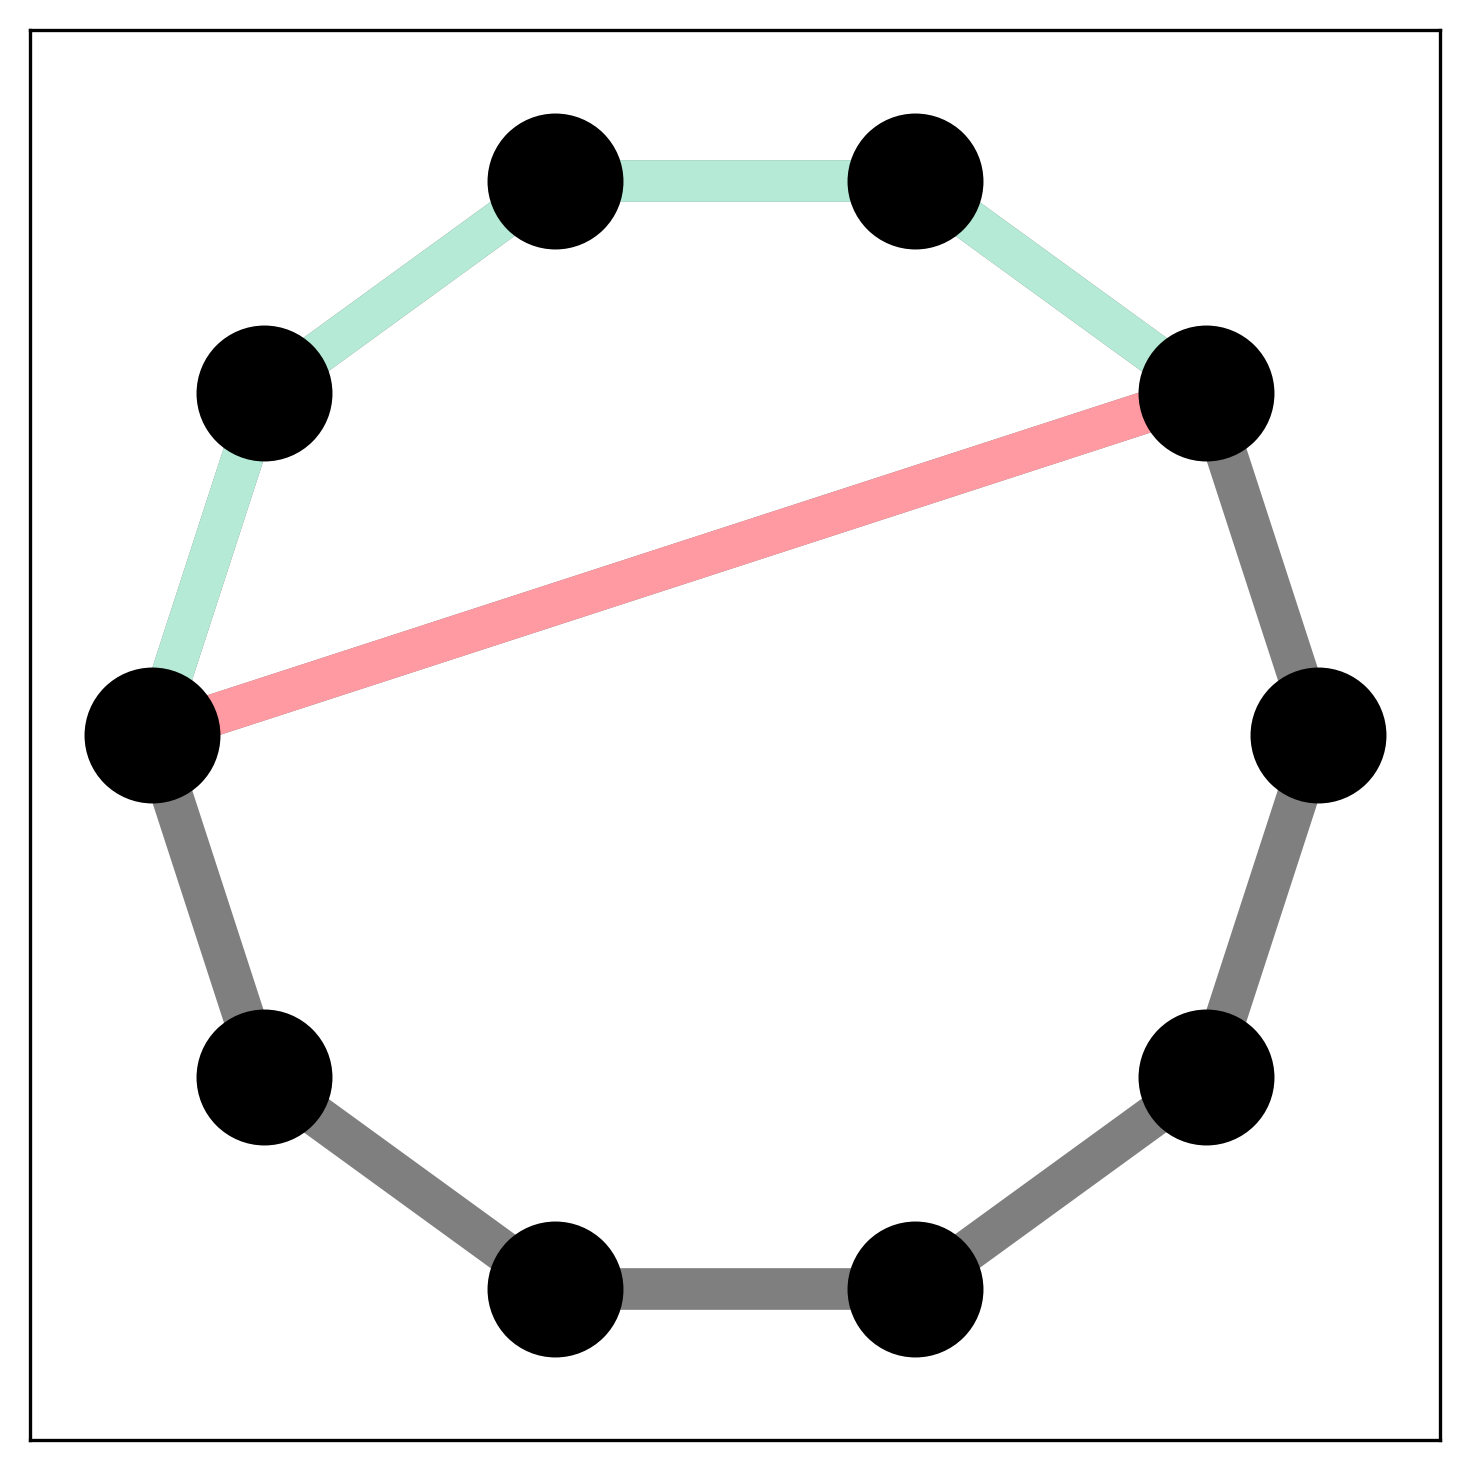

In [15]:
#visualize the network
plt.figure(figsize=(5, 5), dpi=300)

# Remove the black border (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color='black')
nx.draw_networkx_edges(graph, pos, alpha=0.5, width=10)
#draw the tie from node 1 to node 5 in red and all ties in between in green
nx.draw_networkx_edges(graph, pos, edgelist=[(1, 5)], edge_color='#FF9AA2', width=10)
nx.draw_networkx_edges(graph, pos, edgelist=[(1, 2), (2,3), (3,4), (4,5)], edge_color='#B5EAD7', width=10)

#nx.draw_networkx_labels(graph, pos, font_size=12, font_color='white', font_weight='bold')
plt.tight_layout()
#set axs equal
plt.axis('equal')
    
plt.show()

In [16]:
graph.edges

EdgeView([(0, 1), (0, 9), (1, 2), (1, 5), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)])

In [17]:
#remove the tie between node 1 and 5
graph.remove_edge(1, 5)
#add a tie between node 1 and 3
graph.add_edge(5, 3)

In [18]:
graph.edges

EdgeView([(0, 1), (0, 9), (1, 2), (2, 3), (3, 4), (3, 5), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)])

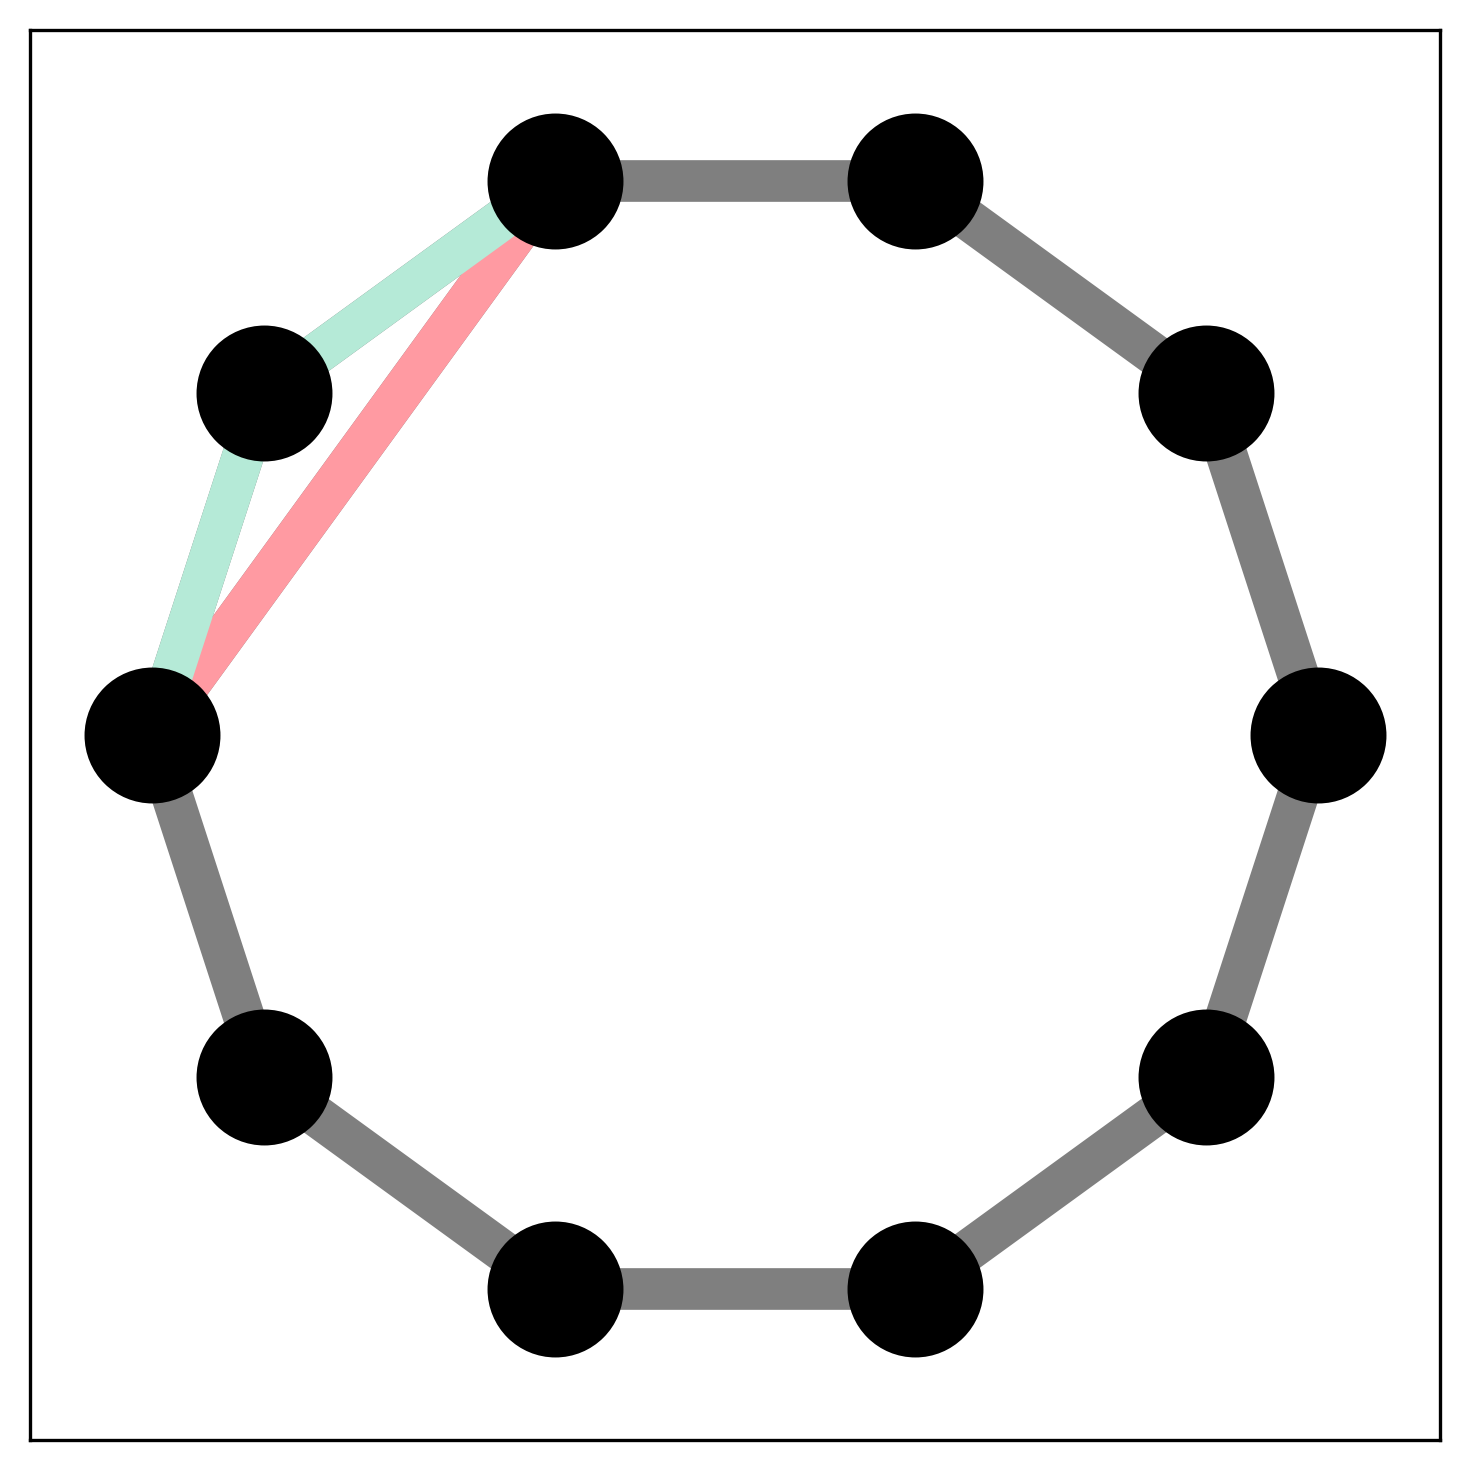

In [19]:
#visualize the network
plt.figure(figsize=(5, 5), dpi=300)
nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color='black')
nx.draw_networkx_edges(graph, pos, alpha=0.5, width=10)
#draw the tie from node 1 to node 5 in red and all ties in between in green
nx.draw_networkx_edges(graph, pos, edgelist=[(5, 3)], edge_color='#FF9AA2', width=10)
nx.draw_networkx_edges(graph, pos, edgelist=[(5, 4), (4,3)], edge_color='#B5EAD7', width=10)

#nx.draw_networkx_labels(graph, pos, font_size=12, font_color='white', font_weight='bold')

plt.tight_layout()
#set axs equal
plt.axis('equal')
plt.show()